# Final Project - Rocket Launch Prediction

    July 19th, 2018
    
[<< Table of Contents](index.html)

## Imports and general classes

Below is the general setup needed by the global application

In [1]:
import numpy as np
from matplotlib import pyplot

# a simple, dynamic data structure for storing values
class Struct: pass

# a 2D cartesian data point container
class XY: 
    def __init__(self, x=0, y=0): 
        self.x, self.y = x, y

# our global constants
CONST = Struct()
CONST.g = 9.81 # m/s^2

## Random Value Sampling for Uncertainties

The following Python class represents a random sampling from an uncertain value space, and is designed to be consumed in the code like a `float` would be (by use of the cannoncial mathematical operators). Though the class is rather verbose, a quick observation will conclude that this class simply takes a random sample given a value and its uncertainty, and stores it in an operator compatible interface. 

In [2]:
##############################################################################
# @class UncertainValue
#     (c) 2018 Kyle West - kyle-west@github.com
#     MIT License. See: [Licensing Info](https://opensource.org/licenses/MIT)
# 
# Create a value from a random +/- uncertainty which can be treated like a
# float or integer. 
#
#    x = UncertainValue(50, 5)  # <--- random sample from 45 to 55. 
#
##############################################################################
from random import uniform

class UncertainValue:
    def __init__ (self, value = 0 , uncertainty = 0):
        self.v = value
        self.u = uncertainty
        self.resample()
        
    def resample(self):
        self.value = uniform(self.v - self.u, self.v + self.u)
        return self.value
        
    def get(self):
        return self.value

    def __float__(self):
        return self.get()
    
    def __radd__(self, other):     return other + self.get()
    def __rmul__(self, other):     return other * self.get()
    def __rlt__(self, other) :     return other < self.get()
    def __rge__(self, other) :     return other >= self.get()
    def __rsub__(self, other):     return other - self.get()
    def __rmod__(self, other):     return other % self.get()
    def __rtruediv__(self, other): return other / self.get()
    def __rle__(self, other):      return other <= self.get()
    def __req__(self, other):      return other == self.get()
    def __rne__(self, other):      return other != self.get()
    def __rgt__(self, other):      return other > self.get()
    
    def __add__(self, other):
        if isinstance(other, self.__class__):
            return self.get() + other.get()
        elif isinstance(other, (int,float)):
            return self.get() + other
    
    def __mul__ (self, other):
        if isinstance(other, self.__class__):
            return self.get() * other.get()
        elif isinstance(other, (float, int)):
            return self.get() * other
    
    def __lt__ (self, other):
        if isinstance(other, self.__class__): 
            return self.get() < other.get()
        elif isinstance(other, (int,float)): 
            return self.get() < other
    
    def __ge__ (self, other):
        if isinstance(other, self.__class__):
            return self.get() >= other.get()
        elif isinstance(other, (int,float)):
            return self.get() >= other
        
    def __sub__ (self, other):
        if isinstance(other, self.__class__):
            return self.get() - other.get()
        elif isinstance(other, (int,float)):
            return self.get() - other

    def __mod__ (self, other):
        if isinstance(other, self.__class__):
            return self.get() % other.get()
        elif isinstance(other, (int,float)):
            return self.get() % other

    def __truediv__ (self, other):
        if isinstance(other, self.__class__):
            return self.get() / other.get()
        elif isinstance(other, (int,float)):
            return self.get() / other

    def __le__ (self, other):
        if isinstance(other, self.__class__):
            return self.get() <= other.get()
        elif isinstance(other, (int,float)):
            return self.get() <= other

    def __eq__ (self, other):
        if isinstance(other, self.__class__):
            return self.get() == other.get()
        elif isinstance(other, (int,float)):
            return self.get() == other

    def __ne__ (self, other):
        if isinstance(other, self.__class__):
            return self.get() != other.get()
        elif isinstance(other, (int,float)):
            return self.get() != other

    def __gt__ (self, other):
        if isinstance(other, self.__class__):
            return self.get() > other.get()
        elif isinstance(other, (int,float)):
            return self.get() > other
        
    def __pow__ (self, other):
        if isinstance(other, self.__class__):
            return self.get() ** other.get()
        elif isinstance(other, (int,float)):
            return self.get() ** other


## Representing the Engine

In order to get a self-contained representation of the **class A8-3** engine, we will use a Python class to keep tract of the engine state. All values come from [this specification](https://www.apogeerockets.com/Rocket_Motors/Estes_Motors/18mm_Motors/Estes_Motors_A8-3).

In [3]:
class Engine:
    def __init__(self, BURN_TIME    = 0.7,     # s
                       TOTAL_MASS   = UncertainValue(0.0167, 0.0002),  # kg
                       FUEL_MASS    = UncertainValue(0.0033, 0.0002),  # kg
                       IMPULSE      = 9.7      # N
                ):
        self.time             = 0.0
        self.running          = True
        self.BURN_TIME        = BURN_TIME;
        self.TOTAL_MASS       = TOTAL_MASS
        self.FUEL_MASS        = FUEL_MASS
        self.IMPULSE          = IMPULSE
        self.BURN_RATE        = FUEL_MASS / BURN_TIME
        self.OUT_OF_FUEL_MASS = self.TOTAL_MASS - self.FUEL_MASS
    
    def getMass(self):
        if not self.running:
            return self.OUT_OF_FUEL_MASS
        else:
            return self.TOTAL_MASS - self.BURN_RATE * self.time
        
    def getThrust(self):
        if not self.running:
            return 0
        else:
            return self.IMPULSE
    
    def incTime(self, value):
        self.time += value
        self.__updateDependants(value)
        
    def __updateDependants(self, dt):
        if (self.time >= self.BURN_TIME):
            self.running = False

## Representing Drag

In [4]:
class Drag:
    def __init__(self, A = 0 , p = 1.29, C = 0.1, v = 1):
        self.value = C * A * .5 * p
        self.A, self.p, self.C = A, p, C

## Representing the Rocket

The rokect has an engine, a parachute, and it's own weight. We will keep track of this using another Python class.

In [5]:
class Rocket:
    def __init__(self, mass                           = UncertainValue(0.0509,0.0002),     # kg
                       PARACHUTE_CROSS_SECTIONAL_AREA = 0.0415,     # m^2
                       TOP_CROSS_SECTIONAL_AREA       = 0.00048,    # m^2
                       SIDE_CROSS_SECTIONAL_AREA      = 0.018,      # m^2
                       windSpeed                      = 0           # m/s 
                ):
        self.engine                         = Engine()
        self.time                           = 0.0
        self.windSpeed                      = windSpeed
        self.PARACHUTE_CROSS_SECTIONAL_AREA = PARACHUTE_CROSS_SECTIONAL_AREA
        self.TOP_CROSS_SECTIONAL_AREA       = TOP_CROSS_SECTIONAL_AREA
        self.SIDE_CROSS_SECTIONAL_AREA      = SIDE_CROSS_SECTIONAL_AREA
        self.mass                           = mass
        self.position                       = XY()
        self.velocity                       = XY()
        self.acceleration                   = XY(
            0, self.engine.IMPULSE/self.getMass() - CONST.g
        )
        
    def parachuteHasDeployed(self):
        return not self.engine.running
    
    # RED FLAG - we don't know if this is right
    def getXDrag(self):
        if self.parachuteHasDeployed():
            drag = Drag(A = self.SIDE_CROSS_SECTIONAL_AREA)
            return drag.value / self.getMass()
        else:
            return 0.0
    
    def getYDrag(self):
        if self.parachuteHasDeployed():
            drag = Drag(A = self.PARACHUTE_CROSS_SECTIONAL_AREA)
        else:
            drag = Drag(A = self.TOP_CROSS_SECTIONAL_AREA)
        return drag.value / self.getMass()
    
    def getMass(self):
        return self.mass + self.engine.getMass()
    
    def incTime(self, value):
        self.time += value
        self.__updateDependants(value)
        
    def __updateDependants(self, dt):
        self.engine.incTime(dt)
        
        magnitude = np.sqrt(self.velocity.x**2 + self.velocity.y**2) * dt
        drag_part_y = - self.getYDrag() * magnitude
        self.acceleration.y = self.engine.getThrust() / self.getMass() - CONST.g
        
        if (self.velocity.x < self.windSpeed):
            drag_part_x =   self.getXDrag() * magnitude
            self.velocity.x += dt * self.acceleration.x + drag_part_x * self.windSpeed
        else:
            self.velocity.x = self.windSpeed
        self.velocity.y += dt * self.acceleration.y + drag_part_y * self.velocity.y
        self.position.x += dt * self.velocity.x
        self.position.y += dt * self.velocity.y
        
        

## Simulator

In [6]:
class RocketSimulator:
    def __init__(self, numTrials = 0, dt = .01, windSpeed = UncertainValue(3.1,1.5)):
        self.dt        = dt
        self.numTrials = numTrials
        self.windSpeed = windSpeed
        
    def resampleValues(self):
        self.windSpeed.resample()
        
    def printTrialReport(self, trialNumber, x, y):
        print ('TRIAL {} of {} | windspeed {:.2f}m/s'.format(trialNumber, self.numTrials, self.windSpeed.get()))
        print ('Max X: {:.2f}m'.format(max(x)))
        print ('Max Y: {:.2f}m'.format(max(y)))
        pyplot.plot(x,y)
        pyplot.show()
        
    def runTrial(self, number, showReport = False):
        self.resampleValues()
        rocket = Rocket(windSpeed = self.windSpeed)
        x = [0]
        y = [0]

        fail_safe = 0
        while (fail_safe < 10000 and rocket.position.y >= 0):
            rocket.incTime(self.dt)
            x.append(rocket.position.x)
            y.append(rocket.position.y)
            fail_safe += 1
        
        if showReport: self.printTrialReport(number, x, y)
            
        trial           = Struct()
        trial.position  = XY(x, y)
        trial.windSpeed = self.windSpeed
        return trial
            
    def summaryReport(self, history):
        Xmax = []
        Ymax = []
        wind = []
        for trial in history:
            Xmax.append(max(trial.position.x))
            Ymax.append(max(trial.position.y))
            wind.append(trial.windSpeed.get())
            pyplot.plot(trial.position.x, trial.position.y)
            
        print ('X Final  Range | Avg: {:.2f}m, Max: {:.2f}m, Min: {:.2f}m'
               .format(sum(Xmax)/len(Xmax), max(Xmax), min(Xmax)))
        print ('Y Height Range | Avg: {:.2f}m, Max: {:.2f}m, Min: {:.2f}m'
               .format(sum(Ymax)/len(Ymax), max(Ymax), max(0, min(Ymax))))
        pyplot.show()
            
    def run(self, showAllReports = False, giveSummaryReport = True):
        history = []
        for trial in range(1, self.numTrials + 1):
            history.append(self.runTrial(trial, showAllReports))
        
        if giveSummaryReport: self.summaryReport(history)
    

# Run the Simulation

Because of our hard work writing modular code, all we have to do now is run the simulation.

X Final  Range | Avg: 21.74m, Max: 33.13m, Min: 11.30m
Y Height Range | Avg: 75.06m, Max: 75.13m, Min: 74.97m


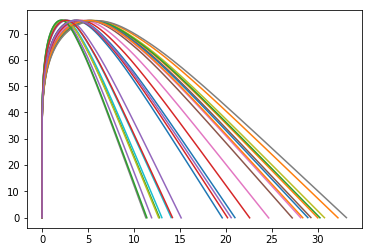

In [7]:
sim = RocketSimulator(numTrials = 25)
sim.run()

## Measurements
Below are the measurements we made on our rocket, needed for the experiment.

>Rocket weight with out the engine: `0.0509 ± .0002 kg`

>Engine weight `0.0167 ± .0002 kg`

>Flame retardent paper: `0.0004 ± .0002 kg`